In [2]:
import pandas as pd
data = pd.read_csv('lightcast_data.csv')

/tmp/ipykernel_7859/1289548112.py:2: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('lightcast_data.csv')


In [14]:
company_series = (
    data["COMPANY_NAME"]
    .dropna()
    .astype(str)
    .str.strip()
)

company_series = company_series[company_series.ne("") & company_series.ne("nan")]

# 1) Show total unique companies
unique_companies = company_series.unique()
print("Total unique COMPANY_NAME values:", len(unique_companies))

# 2) Show the top 50 companies by number of postings (recommended for picking 3)
top_companies = company_series.value_counts().head(50)
print("\nTop 50 companies by postings:\n")
print(top_companies)

# 3) (Optional) print ALL unique company names (can be very long!)
# for name in sorted(unique_companies):
#     print(name)

Total unique COMPANY_NAME values: 12301

Top 50 companies by postings:

COMPANY_NAME
Unclassified                         3984
Deloitte                             2554
Accenture                            1498
PricewaterhouseCoopers                839
KPMG                                  451
Merit America                         444
Insight Global                        442
Lumen Technologies                    424
Humana                                421
Oracle                                392
Smx Corporation Limited               381
Infosys                               370
Randstad                              362
Cardinal Health                       349
Robert Half                           336
Chewy                                 323
Diverse Lynx                          322
Citigroup                             319
Meta                                  314
The Judge Group                       300
The Boston Consulting Group (BCG)     292
CDW                              

In [5]:
# 2) Typecast datetime columns
date_cols = ["POSTED", "EXPIRED", "LAST_UPDATED_DATE"]
for col in date_cols:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors="coerce")

# 3) Typecast numeric columns
num_cols = ["SALARY_FROM", "SALARY_TO", "MIN_YEARS_EXPERIENCE"]
for col in num_cols:
    if col in data.columns:
        # clean symbols like $, commas, text; keep digits/dot/minus
        cleaned = (
            data[col]
            .astype(str)
            .str.replace(r"[^0-9.\-]", "", regex=True)
            .replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
        )
        data[col] = pd.to_numeric(cleaned, errors="coerce")

# 4) Fill missing values (NO inplace on column slice -> avoids FutureWarning)
fill_map = {
    "SALARY_FROM": 0,
    "SALARY_TO": 0,
    "MIN_YEARS_EXPERIENCE": 0
}
existing_fill_map = {k: v for k, v in fill_map.items() if k in data.columns}
data = data.fillna(existing_fill_map)


In [6]:
import os 
# Make sure the output folder exists
os.makedirs("_output", exist_ok=True)

# Save cleaned data
data.to_csv("_output/lightcast_cleaned.csv", index=False)

print("Saved to: _output/lightcast_cleaned.csv")

Saved to: _output/lightcast_cleaned.csv


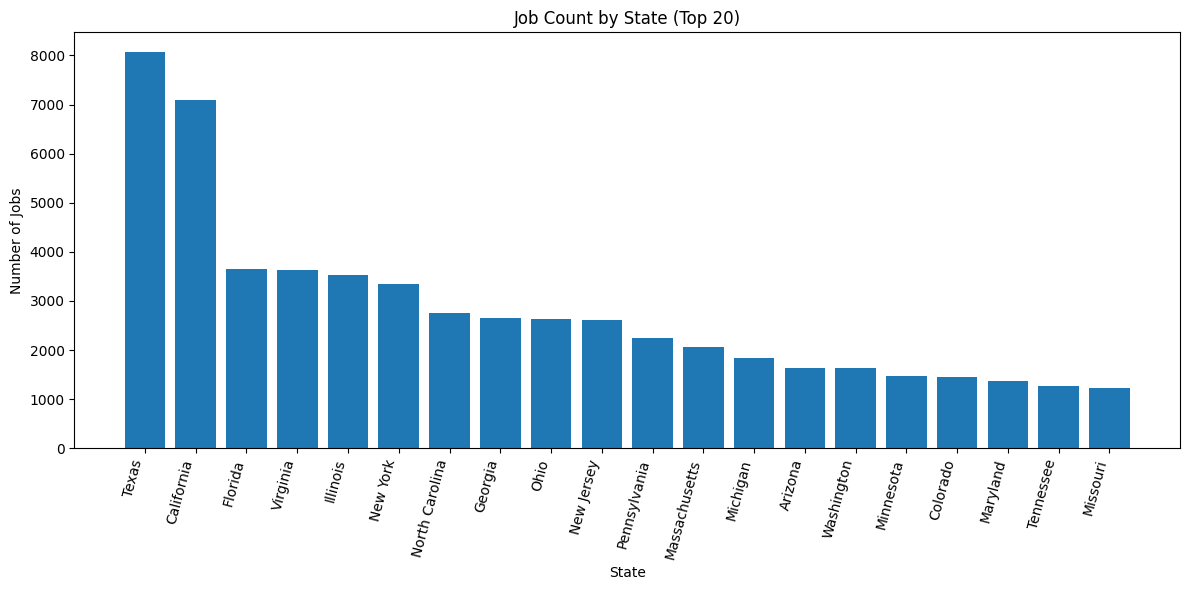

In [23]:
import matplotlib.pyplot as plt

# 1) Group by STATE_NAME and count jobs
state_counts = (
    data.groupby("STATE_NAME")
        .size()
        .sort_values(ascending=False)
)

# (Optional) limit to top N states so the chart is readable
top_n = 20
state_counts_plot = state_counts.head(top_n)

# 2) Plot using Matplotlib (no fixed colors)
plt.figure(figsize=(12, 6))
plt.bar(state_counts_plot.index.astype(str), state_counts_plot.values)
plt.xticks(rotation=75, ha="right")
plt.xlabel("State")
plt.ylabel("Number of Jobs")
plt.title(f"Job Count by State (Top {top_n})")
plt.tight_layout()
plt.savefig("_output/q1_job_count_by_state.png", dpi=300, bbox_inches="tight")
plt.show()

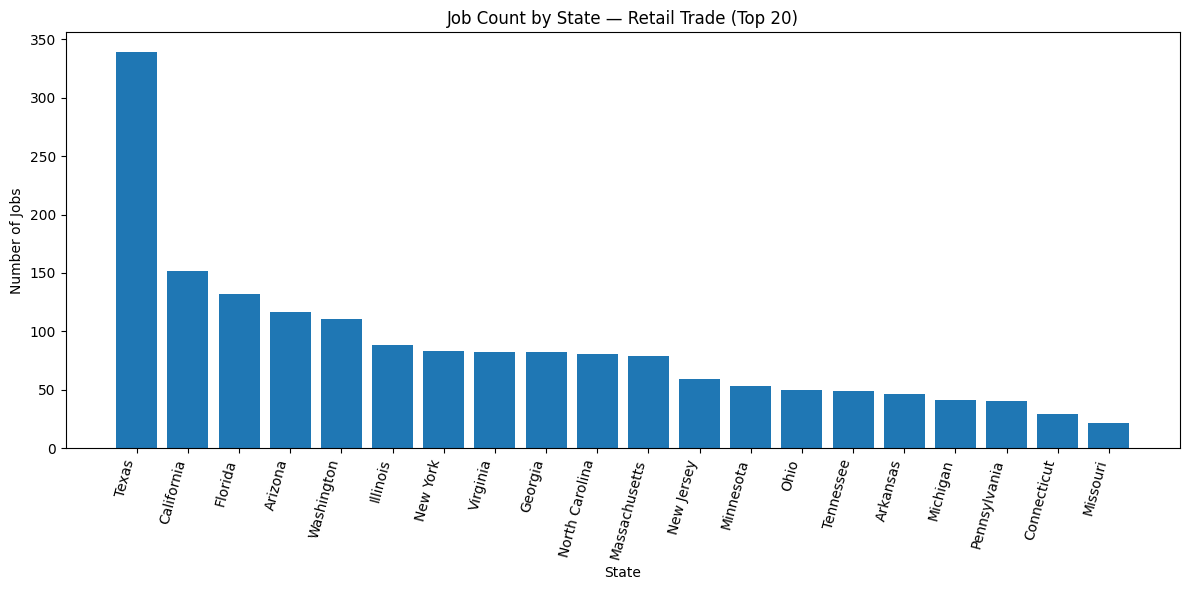

In [24]:

industry = "Retail Trade" 

# 1) Filter for the industry (handles extra spaces / missing)
industry_data = data[data["NAICS2_NAME"].astype(str).str.strip().eq(industry)].copy()

# 2) Group by state and count jobs
state_counts = (
    industry_data.groupby("STATE_NAME")
        .size()
        .sort_values(ascending=False)
)

# (Optional) limit to top N states for readability
top_n = 20
state_counts_plot = state_counts.head(top_n)

# 3) Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(state_counts_plot.index.astype(str), state_counts_plot.values)
plt.xticks(rotation=75, ha="right")
plt.xlabel("State")
plt.ylabel("Number of Jobs")
plt.title(f"Job Count by State — {industry} (Top {top_n})")
plt.tight_layout()
plt.savefig("_output/q2_job_count_by_state_retail_trade.png", dpi=300, bbox_inches="tight")
plt.show()

             COMPANY_NAME  count_may  count_sept  percent_change
0               Accenture        299         425       42.140468
1                Deloitte        885         481      -45.649718
2  PricewaterhouseCoopers        119         162       36.134454


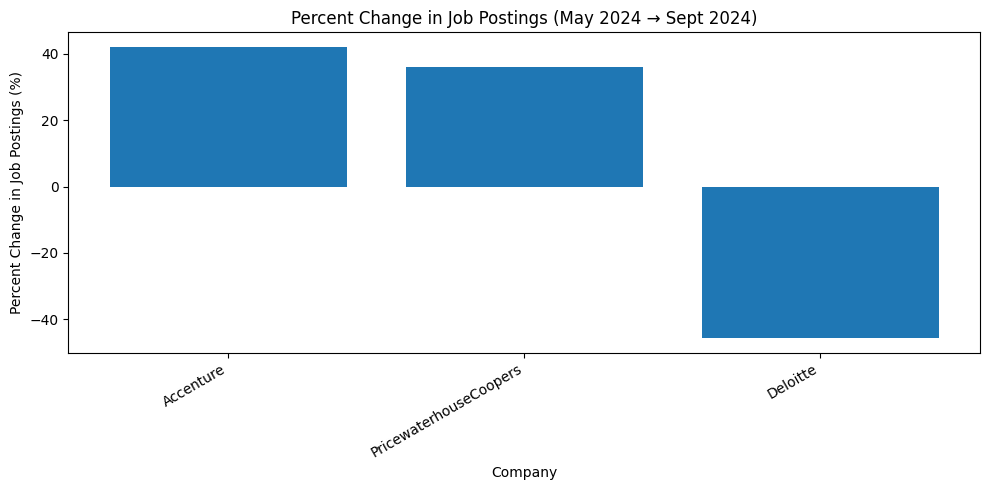

In [25]:
# --- Ensure POSTED is datetime ---
data["POSTED"] = pd.to_datetime(data["POSTED"], errors="coerce")

#   3 companies 
companies = ["Deloitte", "Accenture", "PricewaterhouseCoopers"] 

# --- Target months ---
may_2024 = pd.Period("2024-05", freq="M")
sept_2024 = pd.Period("2024-09", freq="M")

# 1) Filter for those companies
dfc = data[data["COMPANY_NAME"].isin(companies)].copy()

# 2) Create month period from POSTED
dfc["POSTED_MONTH"] = dfc["POSTED"].dt.to_period("M")

# 3) Count job postings by company and month
monthly_counts = (
    dfc.groupby(["COMPANY_NAME", "POSTED_MONTH"])
       .size()
       .reset_index(name="job_count")
)

# 4) Pull May and Sept counts
may_counts = monthly_counts[monthly_counts["POSTED_MONTH"] == may_2024][["COMPANY_NAME", "job_count"]].rename(columns={"job_count": "count_may"})
sept_counts = monthly_counts[monthly_counts["POSTED_MONTH"] == sept_2024][["COMPANY_NAME", "job_count"]].rename(columns={"job_count": "count_sept"})

merged = (pd.merge(may_counts, sept_counts, on="COMPANY_NAME", how="outer")
            .fillna({"count_may": 0, "count_sept": 0}))

# 5) Percent change (avoid divide-by-zero)
merged["percent_change"] = merged.apply(
    lambda r: ((r["count_sept"] - r["count_may"]) / r["count_may"] * 100) if r["count_may"] != 0 else None,
    axis=1
)

print(merged)

# 6) Plot percent change bar chart (drops companies with undefined % change)
plot_df = merged.dropna(subset=["percent_change"]).sort_values("percent_change", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(plot_df["COMPANY_NAME"].astype(str), plot_df["percent_change"].values)
plt.xticks(rotation=30, ha="right")
plt.xlabel("Company")
plt.ylabel("Percent Change in Job Postings (%)")
plt.title("Percent Change in Job Postings (May 2024 → Sept 2024)")
plt.tight_layout()
plt.savefig("_output/q3_percentage_change_job_postings.png", dpi=300, bbox_inches="tight")
plt.show()

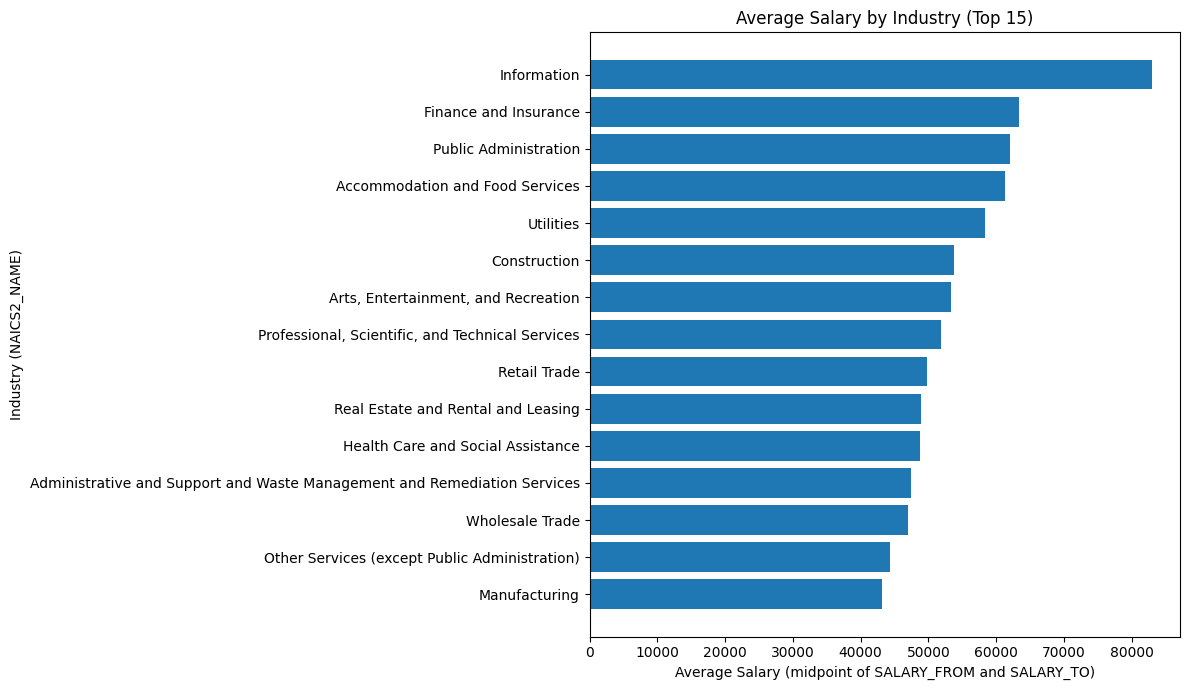

In [26]:
# Make sure salary columns are numeric (in case not already)
for col in ["SALARY_FROM", "SALARY_TO"]:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce")

# 1) Group by industry and compute average salary_from / salary_to
industry_salary = (
    data.dropna(subset=["NAICS2_NAME"])
        .groupby("NAICS2_NAME")[["SALARY_FROM", "SALARY_TO"]]
        .mean()
)

# (Optional) drop industries with both averages missing/zero
industry_salary = industry_salary.dropna(how="all")
industry_salary = industry_salary[(industry_salary["SALARY_FROM"].fillna(0) > 0) | (industry_salary["SALARY_TO"].fillna(0) > 0)]

# Create a single "avg salary" to plot (midpoint of avg range)
industry_salary["AVG_SALARY"] = industry_salary[["SALARY_FROM", "SALARY_TO"]].mean(axis=1)

# Keep top N industries by avg salary for readability
top_n = 15
plot_df = industry_salary.sort_values("AVG_SALARY", ascending=True).tail(top_n)

# 2) Plot horizontal bar chart (no fixed colors)
plt.figure(figsize=(12, 7))
plt.barh(plot_df.index.astype(str), plot_df["AVG_SALARY"].values)
plt.xlabel("Average Salary (midpoint of SALARY_FROM and SALARY_TO)")
plt.ylabel("Industry (NAICS2_NAME)")
plt.title(f"Average Salary by Industry (Top {top_n})")
plt.tight_layout()
plt.savefig("_output/q4_average_salary_by_industry.png", dpi=300, bbox_inches="tight")
plt.show()

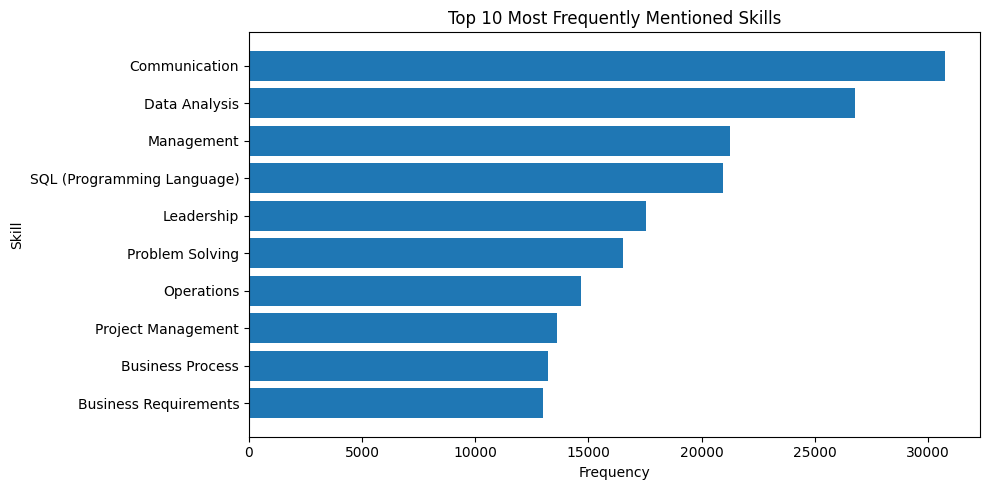

In [27]:
from collections import Counter

# 1) Extract individual skill names (comma-separated), clean whitespace
skills_list = (
    data["SKILLS_NAME"]
    .dropna()
    .astype(str)
    .str.replace('"', "", regex=False)   # remove any stray quotes
    .str.split(",")
    .explode()
    .str.strip()
)

# remove blanks
skills_list = skills_list[skills_list.ne("") & skills_list.ne("nan")]

# 2) Count occurrences + top 10
top10 = Counter(skills_list).most_common(10)

skill_df = pd.DataFrame(top10, columns=["Skill", "Count"]).sort_values("Count", ascending=True)

# 3) Plot (horizontal bar chart)
plt.figure(figsize=(10, 5))
plt.barh(skill_df["Skill"], skill_df["Count"])
plt.title("Top 10 Most Frequently Mentioned Skills")
plt.xlabel("Frequency")
plt.ylabel("Skill")
plt.tight_layout()
plt.savefig("_output/q5_top10_most_frequently_mentioned_skills.png", dpi=300, bbox_inches="tight")
plt.show()
